<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTu8IayzMrmGKgbnT0hGkk6k7FhiK1ICbTNUA&usqp=CAU" />

In [5]:
import os
from acquire import test, grab_telco, prep_t, telco_test, split
from env import username, password, host
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

import sklearn.metrics as mtc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

<div class="alert alert-block alert-success">
    
# Business Goals
## - Find drivers for customer churn at Telco. Why are customers churning?
## - Construct a Machine Learning classification model that accurately predicts customer churn.
## - Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

<div class="alert alert-block alert-info">
    
# Initial Questions:
### Are certain groups (age, gender, etc.) of customers unsatisfied with our service?

### Do we offer products/services(internet types) that do not meet expectations?

### Are we charging too much?

### Do we lack customer support?

### Do we need to put more focus on the types of contracts we offer for customers?

# Acquire and view the data
>We will grab this data from the telco.csv file

In [6]:
telco = grab_telco()
telco.head()

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes
3,3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes
4,4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes


# Look at the column(feature) Dtypes and check for cells with no values (nulls)

In [7]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   customer_id               7043 non-null   object 
 2   gender                    7043 non-null   object 
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   object 
 5   dependents                7043 non-null   object 
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   object 
 8   multiple_lines            7043 non-null   object 
 9   internet_service_type_id  7043 non-null   int64  
 10  online_security           7043 non-null   object 
 11  online_backup             7043 non-null   object 
 12  device_protection         7043 non-null   object 
 13  tech_support              7043 non-null   object 
 14  streamin

---

# Prep the data
>**Create dummy variables for modeling purposes<br>
(1: 'Yes', 0: 'No')**

In [8]:
telco = prep_t(telco)

In [9]:
telco.head(3)

,customer_id,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,streaming_tv_Yes,streaming_movies_Yes,...,churn_Yes,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,online_security_Yes,multiple_lines_Yes
0,0002-ORFBO,0,9,1,2,2,65.6,593.3,1,0,...,0,0,1,1,1,1,0,1,0,0
1,0003-MKNFE,0,9,1,1,2,59.9,542.4,0,1,...,0,1,0,0,1,0,0,0,0,1
2,0004-TLHLJ,0,4,2,1,1,73.9,280.85,0,0,...,1,1,0,0,1,0,1,0,0,0


## Separate Customer ID and Total Charges from the data. 
>**The feature is not needed to run tests, but I'd like to still keep it.<br>
<br>
I do not believe Total Charges will aid in the prediction of churn based on how it is defined(the amount of charges over a customers lifetime with Telco**.

In [11]:
customers = telco[['customer_id', 'total_charges']]
customers.head()

,customer_id,total_charges
0,0002-ORFBO,593.3
1,0003-MKNFE,542.4
2,0004-TLHLJ,280.85
3,0011-IGKFF,1237.85
4,0013-EXCHZ,267.4


## ... And then make sure the dataset reflects that change

In [12]:
telco = telco.loc[:, telco.columns != 'total_charges']
telco.head()

,customer_id,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,online_security_Yes,multiple_lines_Yes
0,0002-ORFBO,0,9,1,2,2,65.6,1,0,1,0,0,1,1,1,1,0,1,0,0
1,0003-MKNFE,0,9,1,1,2,59.9,0,1,0,0,1,0,0,1,0,0,0,0,1
2,0004-TLHLJ,0,4,2,1,1,73.9,0,0,1,1,1,0,0,1,0,1,0,0,0
3,0011-IGKFF,1,13,2,1,1,98.0,1,1,1,1,1,1,0,1,1,1,0,0,0
4,0013-EXCHZ,1,3,2,1,2,83.9,1,0,1,1,0,1,0,1,0,0,1,0,0


### Now all features are numerical values

## Additionally, I want to make sure I don't forget what each value represents for the categorical data:

### Internet Service Type:
> 1. DSL
2. Fiber Optic
3. None

### Payment Type: 
> 1. Electronic check
2. Mailed check
3. Bank Transfer
4. CC

### Contract Type: 
> 1. Month-to-Month
2. One-year
3. Two-year

---

# I ran statistical tests on the whole dataset to give initial direction

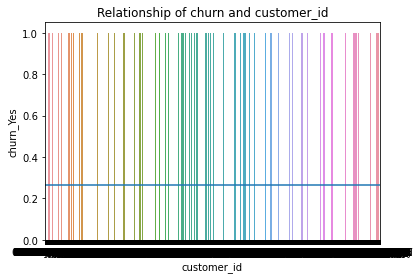

We fail to reject that churn_Yes and customer_id are independent
There appears to be no relationship between customer_id and churn_Yes
None
-------
customer_id  0002-ORFBO  0003-MKNFE  0004-TLHLJ  0011-IGKFF  0013-EXCHZ  \
churn_Yes                                                                 
0                     1           1           0           0           0   
1                     0           0           1           1           1   

customer_id  0013-MHZWF  0013-SMEOE  0014-BMAQU  0015-UOCOJ  0016-QLJIS  ...  \
churn_Yes                                                                ...   
0                     1           1           1           1           1  ...   
1                     0           0           0           0           0  ...   

customer_id  9975-SKRNR  9978-HYCIN  9979-RGMZT  9985-MWVIX  9986-BONCE  \
churn_Yes                                                                 
0                     1           1           1           0           0   
1    

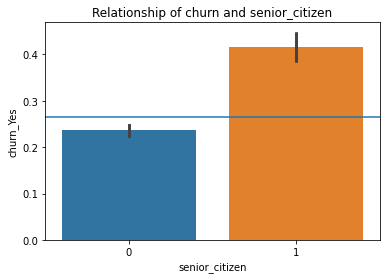

We reject that churn_Yes and senior_citizen are independent
There is a relationship between senior_citizen and churn_Yes
None
-------
senior_citizen     0    1
churn_Yes                
0               4508  666
1               1393  476
-------
(159.42630036838742, 1.510066805092378e-36, 1, array([[4335.05239245,  838.94760755],
       [1565.94760755,  303.05239245]]))
-------
0    5901
1    1142
Name: senior_citizen, dtype: int64
0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64


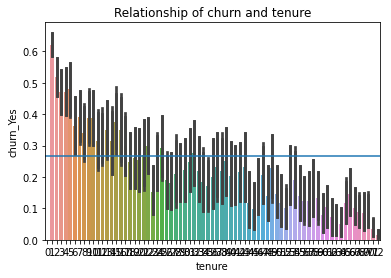

We reject that churn_Yes and tenure are independent
There is a relationship between tenure and churn_Yes
None
-------
tenure     0    1    2    3   4   5   6   7   8   9   ...  63  64  65  66  67  \
churn_Yes                                             ...                       
0          11  233  115  106  93  69  70  80  81  73  ...  68  76  67  76  88   
1           0  380  123   94  83  64  40  51  42  46  ...   4   4   9  13  10   

tenure     68  69   70   71   72  
churn_Yes                         
0          91  87  108  164  356  
1           9   8   11    6    6  

[2 rows x 73 columns]
-------
(1065.3308567510544, 1.2807811055496877e-176, 72, array([[  8.08093142, 450.3282692 , 174.84197075, 146.92602584,
        129.29490274,  97.70580718,  80.80931421,  96.23654693,
         90.35950589,  87.42098538,  85.21709499,  72.72838279,
         85.95172512,  80.07468408,  55.83188982,  72.72838279,
         58.77041034,  63.91282124,  71.25912253,  53.62799943,
         52.1587

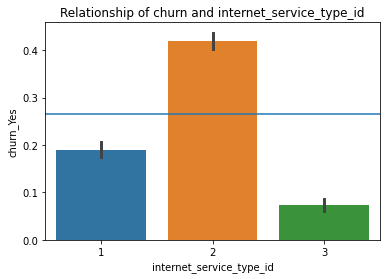

We reject that churn_Yes and internet_service_type_id are independent
There is a relationship between internet_service_type_id and churn_Yes
None
-------
internet_service_type_id     1     2     3
churn_Yes                                 
0                         1962  1799  1413
1                          459  1297   113
-------
(732.309589667794, 9.571788222840544e-160, 2, array([[1778.53954281, 2274.41488002, 1121.04557717],
       [ 642.46045719,  821.58511998,  404.95442283]]))
-------
2    3096
1    2421
3    1526
Name: internet_service_type_id, dtype: int64
2    0.439585
1    0.343746
3    0.216669
Name: internet_service_type_id, dtype: float64


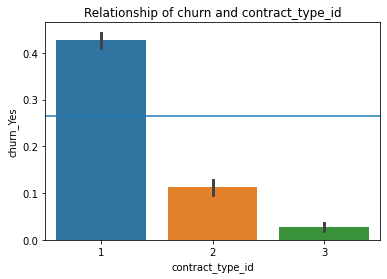

We reject that churn_Yes and contract_type_id are independent
There is a relationship between contract_type_id and churn_Yes
None
-------
contract_type_id     1     2     3
churn_Yes                         
0                 2220  1307  1647
1                 1655   166    48
-------
(1184.5965720837926, 5.863038300673391e-258, 2, array([[2846.69175067, 1082.11018032, 1245.198069  ],
       [1028.30824933,  390.88981968,  449.801931  ]]))
-------
1    3875
3    1695
2    1473
Name: contract_type_id, dtype: int64
1    0.550192
3    0.240664
2    0.209144
Name: contract_type_id, dtype: float64


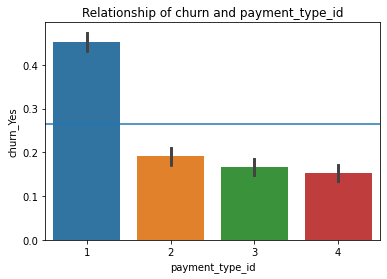

We reject that churn_Yes and payment_type_id are independent
There is a relationship between payment_type_id and churn_Yes
None
-------
payment_type_id     1     2     3     4
churn_Yes                              
0                1294  1304  1286  1290
1                1071   308   258   232
-------
(648.1423274814, 3.6823546520097993e-140, 3, array([[1737.40025557, 1184.22376828, 1134.26891949, 1118.10705665],
       [ 627.59974443,  427.77623172,  409.73108051,  403.89294335]]))
-------
1    2365
2    1612
3    1544
4    1522
Name: payment_type_id, dtype: int64
1    0.335794
2    0.228880
3    0.219225
4    0.216101
Name: payment_type_id, dtype: float64


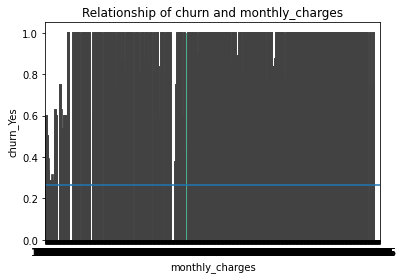

We reject that churn_Yes and monthly_charges are independent
There is a relationship between monthly_charges and churn_Yes
None
-------
monthly_charges  18.25   18.40   18.55   18.70   18.75   18.80   18.85   \
churn_Yes                                                                 
0                     1       1       1       2       1       7       4   
1                     0       0       0       0       0       0       1   

monthly_charges  18.90   18.95   19.00   ...  117.35  117.45  117.50  117.60  \
churn_Yes                                ...                                   
0                     2       5       6  ...       1       0       1       1   
1                     0       1       1  ...       0       1       0       0   

monthly_charges  117.80  118.20  118.35  118.60  118.65  118.75  
churn_Yes                                                        
0                     0       1       0       2       1       1  
1                     1       0       1     

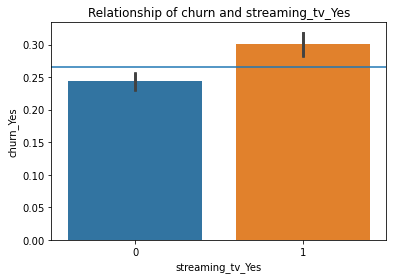

We reject that churn_Yes and streaming_tv_Yes are independent
There is a relationship between streaming_tv_Yes and churn_Yes
None
-------
streaming_tv_Yes     0     1
churn_Yes                   
0                 3281  1893
1                 1055   814
-------
(27.862522274233417, 1.3024835736732686e-07, 1, array([[3185.35624024, 1988.64375976],
       [1150.64375976,  718.35624024]]))
-------
0    4336
1    2707
Name: streaming_tv_Yes, dtype: int64
0    0.615647
1    0.384353
Name: streaming_tv_Yes, dtype: float64


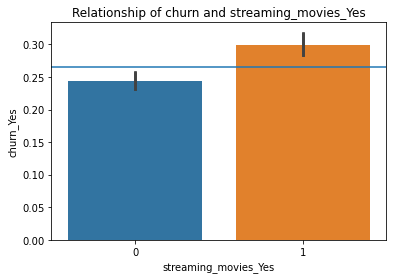

We reject that churn_Yes and streaming_movies_Yes are independent
There is a relationship between streaming_movies_Yes and churn_Yes
None
-------
streaming_movies_Yes     0     1
churn_Yes                       
0                     3260  1914
1                     1051   818
-------
(26.251336010038468, 2.997473847626761e-07, 1, array([[3166.99048701, 2007.00951299],
       [1144.00951299,  724.99048701]]))
-------
0    4311
1    2732
Name: streaming_movies_Yes, dtype: int64
0    0.612097
1    0.387903
Name: streaming_movies_Yes, dtype: float64


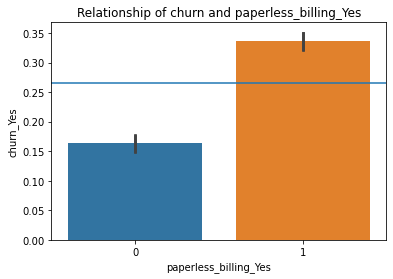

We reject that churn_Yes and paperless_billing_Yes are independent
There is a relationship between paperless_billing_Yes and churn_Yes
None
-------
paperless_billing_Yes     0     1
churn_Yes                        
0                      2403  2771
1                       469  1400
-------
(258.27764906707307, 4.073354668665985e-58, 1, array([[2109.85773108, 3064.14226892],
       [ 762.14226892, 1106.85773108]]))
-------
1    4171
0    2872
Name: paperless_billing_Yes, dtype: int64
1    0.592219
0    0.407781
Name: paperless_billing_Yes, dtype: float64


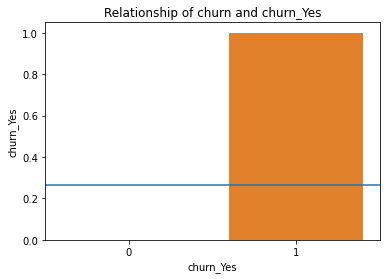

We reject that churn_Yes and churn_Yes are independent
There is a relationship between churn_Yes and churn_Yes
None
-------
churn_Yes     0     1
churn_Yes            
0          5174     0
1             0  1869
-------
(7037.871379458012, 0.0, 1, array([[3800.97628851, 1373.02371149],
       [1373.02371149,  495.97628851]]))
-------
0    5174
1    1869
Name: churn_Yes, dtype: int64
0    0.73463
1    0.26537
Name: churn_Yes, dtype: float64


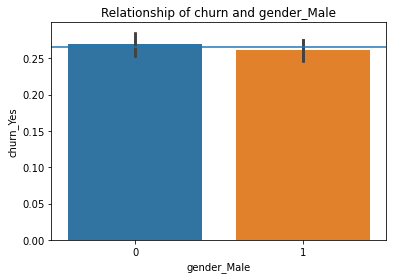

We fail to reject that churn_Yes and gender_Male are independent
There appears to be no relationship between gender_Male and churn_Yes
None
-------
gender_Male     0     1
churn_Yes              
0            2549  2625
1             939   930
-------
(0.4840828822091383, 0.48657873605618596, 1, array([[2562.38989067, 2611.61010933],
       [ 925.61010933,  943.38989067]]))
-------
1    3555
0    3488
Name: gender_Male, dtype: int64
1    0.504756
0    0.495244
Name: gender_Male, dtype: float64


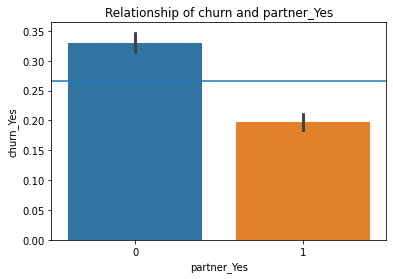

We reject that churn_Yes and partner_Yes are independent
There is a relationship between partner_Yes and churn_Yes
None
-------
partner_Yes     0     1
churn_Yes              
0            2441  2733
1            1200   669
-------
(158.7333820309922, 2.1399113440759935e-36, 1, array([[2674.78830044, 2499.21169956],
       [ 966.21169956,  902.78830044]]))
-------
0    3641
1    3402
Name: partner_Yes, dtype: int64
0    0.516967
1    0.483033
Name: partner_Yes, dtype: float64


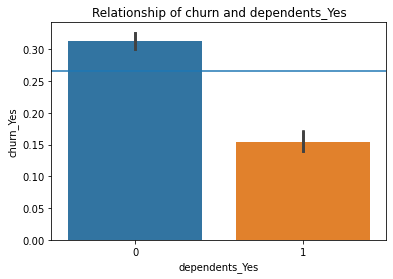

We reject that churn_Yes and dependents_Yes are independent
There is a relationship between dependents_Yes and churn_Yes
None
-------
dependents_Yes     0     1
churn_Yes                 
0               3390  1784
1               1543   326
-------
(189.12924940423474, 4.9249216612154196e-43, 1, array([[3623.93042737, 1550.06957263],
       [1309.06957263,  559.93042737]]))
-------
0    4933
1    2110
Name: dependents_Yes, dtype: int64
0    0.700412
1    0.299588
Name: dependents_Yes, dtype: float64


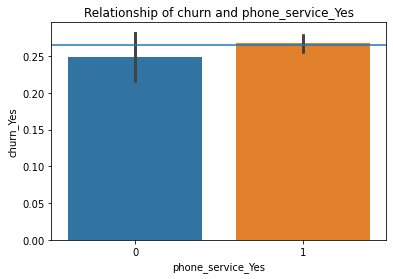

We fail to reject that churn_Yes and phone_service_Yes are independent
There appears to be no relationship between phone_service_Yes and churn_Yes
None
-------
phone_service_Yes    0     1
churn_Yes                   
0                  512  4662
1                  170  1699
-------
(0.9150329892546948, 0.3387825358066928, 1, array([[ 501.01774812, 4672.98225188],
       [ 180.98225188, 1688.01774812]]))
-------
1    6361
0     682
Name: phone_service_Yes, dtype: int64
1    0.903166
0    0.096834
Name: phone_service_Yes, dtype: float64


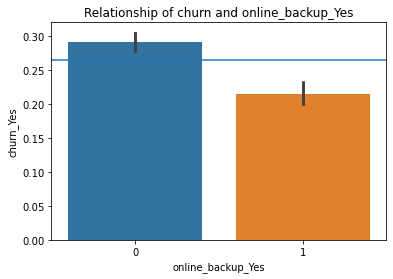

We reject that churn_Yes and online_backup_Yes are independent
There is a relationship between online_backup_Yes and churn_Yes
None
-------
online_backup_Yes     0     1
churn_Yes                    
0                  3268  1906
1                  1346   523
-------
(47.260854003612764, 6.214092807254819e-12, 1, array([[3389.58341616, 1784.41658384],
       [1224.41658384,  644.58341616]]))
-------
0    4614
1    2429
Name: online_backup_Yes, dtype: int64
0    0.655119
1    0.344881
Name: online_backup_Yes, dtype: float64


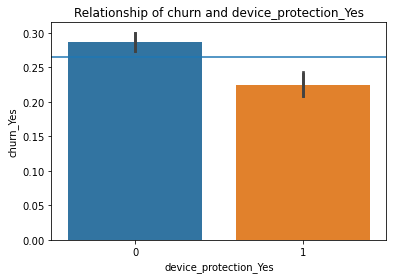

We reject that churn_Yes and device_protection_Yes are independent
There is a relationship between device_protection_Yes and churn_Yes
None
-------
device_protection_Yes     0     1
churn_Yes                        
0                      3297  1877
1                      1324   545
-------
(30.513394539261302, 3.315693222362868e-08, 1, array([[3394.72582706, 1779.27417294],
       [1226.27417294,  642.72582706]]))
-------
0    4621
1    2422
Name: device_protection_Yes, dtype: int64
0    0.656112
1    0.343888
Name: device_protection_Yes, dtype: float64


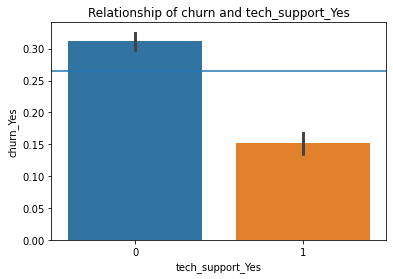

We reject that churn_Yes and tech_support_Yes are independent
There is a relationship between tech_support_Yes and churn_Yes
None
-------
tech_support_Yes     0     1
churn_Yes                   
0                 3440  1734
1                 1559   310
-------
(190.16684201526067, 2.9235674453140758e-43, 1, array([[3672.4160159, 1501.5839841],
       [1326.5839841,  542.4160159]]))
-------
0    4999
1    2044
Name: tech_support_Yes, dtype: int64
0    0.709783
1    0.290217
Name: tech_support_Yes, dtype: float64


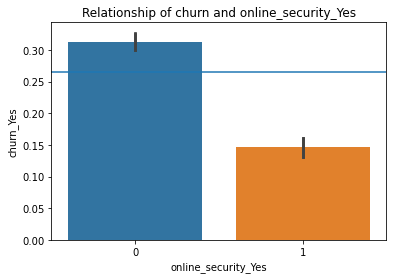

We reject that churn_Yes and online_security_Yes are independent
There is a relationship between online_security_Yes and churn_Yes
None
-------
online_security_Yes     0     1
churn_Yes                      
0                    3450  1724
1                    1574   295
-------
(205.63310416062058, 1.2320984831180024e-46, 1, array([[3690.78176913, 1483.21823087],
       [1333.21823087,  535.78176913]]))
-------
0    5024
1    2019
Name: online_security_Yes, dtype: int64
0    0.713332
1    0.286668
Name: online_security_Yes, dtype: float64


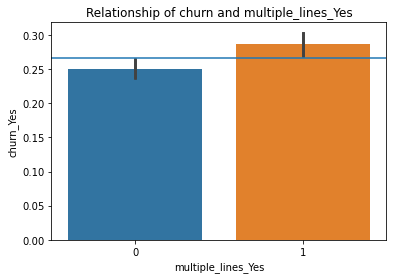

We reject that churn_Yes and multiple_lines_Yes are independent
There is a relationship between multiple_lines_Yes and churn_Yes
None
-------
multiple_lines_Yes     0     1
churn_Yes                     
0                   3053  2121
1                   1019   850
-------
(11.143251001456253, 0.0008433795342472412, 1, array([[2991.41388613, 2182.58611387],
       [1080.58611387,  788.41388613]]))
-------
0    4072
1    2971
Name: multiple_lines_Yes, dtype: int64
0    0.578163
1    0.421837
Name: multiple_lines_Yes, dtype: float64


In [13]:
telco_test(telco)

<div class="alert alert-block alert-success">
    
## For now, I want to focus on:
**Internet Service Type:**<br>
> Fiber Optic reprsents almost half of customers, yet churn at over twice the rate of other internet types.<br>

**Online Backup:**<br>
> The population without online back is twice as large as those who do, yet churn 10% more.

**Device Protection:**<br>
> 2/3 of customer don't have device protection and churn more often that those who do, it could be beneficial to target them.

**Tech Support:**<br>
> Almost 3/4 of customers don't utilize Tech Support and churn twice as often as those who do

**Online Security:**<br>
> Over 70% of customer do not have Online security yet churn twice as fast as those who do.

**Payment Type:**
> Electronic Check payments churn at almost 2.5x the rate of any other payment method and represent a third of all customers.
    
**Age:**<br>
> Senior Citizens are twice as likely to churn than their younger counter parts.

**Tenure:**<br>
> It's clear that long-term customers are less and less likely to churn over time.



### I chose these features based on the statistical relationship coupled with the proportion of each features 'Yes' or 'No'
### I decided against using the rest of the features due to either lack of relationship or other factors that cannot be controlled
> **Example**: Dependents, those with no dependents churn at twice the rate of those who do have dependents, but that does not indicate the reason thye do so.

# Focus on those features

In [14]:
telco = telco[['customer_id', 
               'internet_service_type_id',
               'payment_type_id',
               'tenure',
               'paperless_billing_Yes',
               'churn_Yes',
               'phone_service_Yes',
               'online_backup_Yes',
               'tech_support_Yes',
               'online_security_Yes']]
telco.head(3)

,customer_id,internet_service_type_id,payment_type_id,tenure,paperless_billing_Yes,churn_Yes,phone_service_Yes,online_backup_Yes,tech_support_Yes,online_security_Yes
0,0002-ORFBO,1,2,9,1,0,1,1,1,0
1,0003-MKNFE,1,2,9,0,0,1,0,0,0
2,0004-TLHLJ,2,1,4,1,1,1,0,0,0


---

---

# Understand how the data is shaped to make sure it is properly split in Train, Validate, and Test

In [17]:
telco.shape

(7043, 10)

---

# Split the data
>**Train, Validate, and Test**

In [18]:
train, validate, test = split(telco)
train.shape, validate.shape, test.shape

((4225, 10), (1409, 10), (1409, 10))

In [19]:
train.head(3)

,customer_id,internet_service_type_id,payment_type_id,tenure,paperless_billing_Yes,churn_Yes,phone_service_Yes,online_backup_Yes,tech_support_Yes,online_security_Yes
531,0781-LKXBR,2,1,9,1,1,1,0,0,0
484,0707-HOVVN,1,3,70,1,0,1,1,1,0
4224,5960-MVTUK,1,1,3,1,0,0,0,1,0


# Baseline
>**Establish the baseline rate of Churn (on train)**

In [20]:
train.churn_Yes.value_counts()

0    3122
1    1103
Name: churn_Yes, dtype: int64

In [23]:
baseline_accuracy = 3122/4225
baseline_accuracy

0.7389349112426036

# Set the X,Y Train
>**Dropping churn from x train<br>
Additionally, Customer ID needs to be separated before models are made**

In [24]:
x_train = train.drop(columns=['churn_Yes', 'customer_id'])
y_train = train.churn_Yes
train_id = train.customer_id

x_validate = validate.drop(columns=['churn_Yes', 'customer_id'])
y_validate = validate.churn_Yes
validate_id = validate.customer_id

x_test = test.drop(columns=['churn_Yes', 'customer_id'])
y_test = test.churn_Yes
test_id = test.customer_id

---

# Best 3 Models Discovered

>### Decision Tree (max_depth=3)<br>
>### KNN (nearest 10)<br>
>### Logistic Regression

# Decision Tree
### I used a low depth to avoid overfitting

In [25]:
tree = DecisionTreeClassifier(max_depth=3)

In [26]:
tree = tree.fit(x_train, y_train)
y_predict = tree.predict(x_train)
y_pred_prob = tree.predict_proba(x_train)

In [27]:
cm = pd.DataFrame(confusion_matrix(y_train, y_predict))

## Train
**Model Score**: 79.67% <br>
**Precision**: 82%<br>
**Recall**: 93% <br>
**F1 Score**: 87%

In [28]:
print(classification_report(y_train, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3122
           1       0.68      0.41      0.51      1103

    accuracy                           0.80      4225
   macro avg       0.75      0.67      0.69      4225
weighted avg       0.78      0.80      0.78      4225



## Validate
**Model Score**: 77.50%<br>
**Precision**: 80%<br>
**Recall**: 93%<br>
**F1 Score**: 86%

In [29]:
y_pred_val = tree.predict(x_validate)
print(classification_report(y_validate, y_pred_val))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1020
           1       0.67      0.37      0.48       389

    accuracy                           0.78      1409
   macro avg       0.73      0.65      0.67      1409
weighted avg       0.76      0.78      0.75      1409



---

# Logistic Regression

In [30]:
logit = LogisticRegression(random_state=248)

In [31]:
logit.fit(x_train, y_train)

LogisticRegression(random_state=248)

In [32]:
y_pred_lr = logit.predict(x_train)

## Train

**Model/Accuracy Score**: 78%<br>
**Precision**: 81%<br>
**Recall**: 91%<br>
**F1 Score**: 86%

In [34]:
print(classification_report(y_train, y_pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3122
           1       0.61      0.40      0.48      1103

    accuracy                           0.78      4225
   macro avg       0.71      0.65      0.67      4225
weighted avg       0.76      0.78      0.76      4225



## Validate

**Model/Accuracy Score**: 75%<br>
**Precision**: 79%<br>
**Recall**: 90%<br>
**F1 Score**: 84%

In [35]:
y_pred_lr_val = logit.predict(x_validate)

In [36]:
print(classification_report(y_validate, y_pred_lr_val))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1020
           1       0.58      0.37      0.45       389

    accuracy                           0.75      1409
   macro avg       0.68      0.63      0.65      1409
weighted avg       0.73      0.75      0.73      1409



---

# KNN (nearest 10)

In [37]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn = knn.fit(x_train, y_train)

In [38]:
y_predict_knn = knn.predict(x_train)

In [39]:
y_pred_prob_knn = knn.predict_proba(x_train)

## Train

**Model/Accuracy Score**: 81%<br>
**Precision**: 83%<br>
**Recall**: 93%<br>
**F1 Score**: 88%

In [40]:
print(classification_report(y_train, y_predict_knn))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3122
           1       0.71      0.47      0.57      1103

    accuracy                           0.81      4225
   macro avg       0.77      0.70      0.72      4225
weighted avg       0.80      0.81      0.80      4225



## Validate

**Model/Accuracy Score**: 77%<br>
**Precision**: 80%<br>
**Recall**: 90%<br>
**F1 Score**: 85%

In [41]:
y_predict_knn_val = knn.predict(x_validate)

In [42]:
print(classification_report(y_validate, y_predict_knn_val))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1020
           1       0.62      0.40      0.48       389

    accuracy                           0.77      1409
   macro avg       0.71      0.65      0.67      1409
weighted avg       0.75      0.77      0.75      1409



# The Overall Best Model is... Decision Tree

 ### Test:
**Model Score**: 79%<br>
**Precision**: 81%<br>
**Recall**: 92%<br>
**F1 Score**: 86%

In [44]:
y_pred_test = tree.predict(x_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1032
           1       0.66      0.43      0.52       377

    accuracy                           0.79      1409
   macro avg       0.74      0.67      0.69      1409
weighted avg       0.77      0.79      0.77      1409



<div class="alert alert-block alert-warning">

# Recommendations:
    
> **Focus efforts on offering discounted or free online security<br>
    Same for Tech Support**

# If I could do further analysis, I would explore tenure and age more closely

### Those who are senior citizens are about 16% of customers, but churn twice as much as their younger counterparts
### See more precisely in tenure to target to keep customers early on
### Understand why those opted into paperless billing churn at high rates

---